# 6.6 Sourcing & Analyzing Time Series Data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or feature.
plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear. 

In [2]:
# To ensures the graphs we create are displayed in the notebook without the need to "call" them specifically, we use the code below
%matplotlib inline

In [3]:
# Assign the path of the Gun Violence data folder to the variable 'path'.
path = r'C:\Users\ramis\OneDrive\JC\Data Analytics Course\Data Analytics Immersion\A6\Gun Violence'

In [4]:
# import clean data df_gv_clean.pkl
df_gv_clean = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'df_gv_clean.pkl'))

In [5]:
df_gv_clean.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,incident_characteristics,latitude,longitude,participant_age,participant_age_group,participant_gender,participant_status,participant_type,age_group_classification,severity_of_incident
0,461105,2013-01-01,Pennsylvania,Mckeesport,0,4,14.0,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,-79.8559,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,Known Age Group,Mass Shooting
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,-118.3330,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,Known Age Group,Mass Shooting
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,Known Age Group,Mass Shooting
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,Known Age Group,Mass Shooting
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,Known Age Group,Mass Shooting


### 2. Subsetting and wrangling time-series data:
According to the dataset details on Kaggle: "Stage 1: For each date between 1/1/2013 and 3/31/2018, a Python script queried all incidents that happened at that particular date, then scraped the data and wrote it to a CSV file. Each month got its own CSV file, with the exception of 2013, since not many incidents were recorded from then."

I will confirm the earliest and latest dates present in the data with the subsequent line of code. 
Due to the remark made in the description regarding 2013, I would prefer to exclude 2013 from our analysis. 
Therefore, I will create a subset of the dataframe which includes only the 'date' column and a column called 'n_casualties' which will be derived from adding 'n_killed' and 'n_injured' columns. This means, the time series analysis will focus on the 'n_casualties'starting 01-01-2014.

In [32]:
# Check min and max date values in the 'date' column
min_date = df_gv_clean['date'].min()
max_date = df_gv_clean['date'].max()

min_date, max_date

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [34]:
# Creating a subset dataframe with 'date' column and a new 'n_casualties' column
data_1 = df_gv_clean[['date']].copy()
data_1['n_casualties'] = df_gv_clean['n_killed'] + df_gv_clean['n_injured']

data_1.head()

,date,n_casualties
0,2013-01-01,4
1,2013-01-01,4
2,2013-01-01,4
3,2013-01-05,4
4,2013-01-07,4


In [50]:
# Create a subdata set starting from 2014-01-01
data_sub = data_1.loc[(data_1['date'] >= '2014-01-01')]

In [51]:
data_sub.shape

(231478, 2)

In [52]:
data_sub.head()

,date,n_casualties
278,2014-01-01,0
279,2014-01-01,0
280,2014-01-01,1
281,2014-01-01,1
282,2014-01-01,1


In [53]:
# Set the "date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "date"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
data_sub.head()

,n_casualties
datetime,
2014-01-01,0
2014-01-01,0
2014-01-01,1
2014-01-01,1
2014-01-01,1


In [54]:
# Check for missing values
data_sub.isnull().sum() 

n_casualties    0
dtype: int64

### 3. Create a line chart of the data.

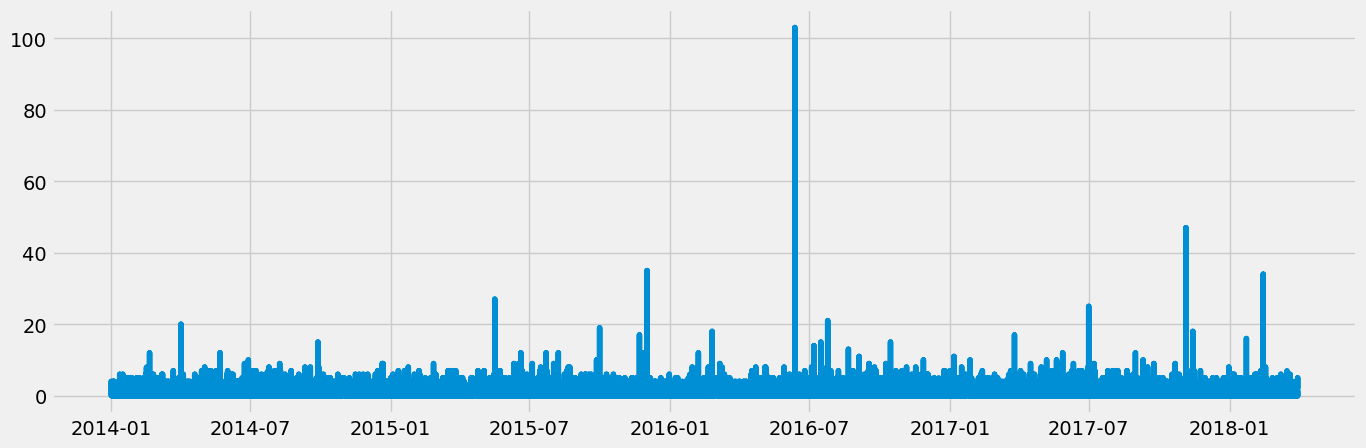

In [55]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

#### As we can see above, there are lots of  fluctuations and noise in the data. This is due to the fact that the 'date' column includes the date of each gun violence incident with a row for each incident. Thus, I chose to aggregate the data by month to decrease the variability, or range, of the data.

In [56]:
# Aggregate the data by month
monthly_aggregated_data = data_sub.resample('M').sum()

# Display the first few rows to verify
monthly_aggregated_data.head()

,n_casualties
datetime,
2014-01-31,2935
2014-02-28,2058
2014-03-31,2542
2014-04-30,2743
2014-05-31,3190


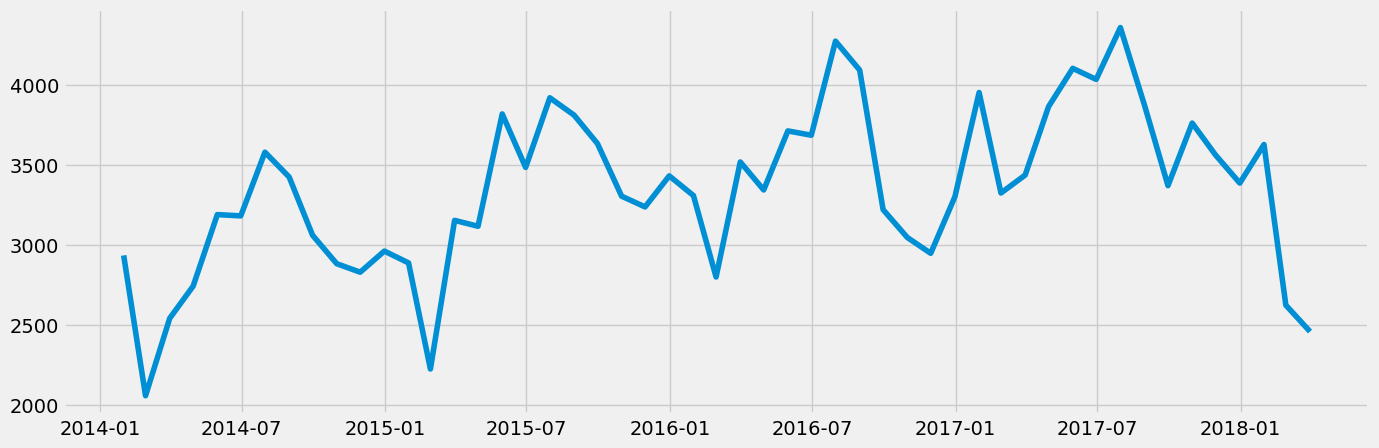

In [58]:
# Plot the new aggregated data set monthly_aggregated_data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(monthly_aggregated_data)

### 4. Decompose the data’s components

In [59]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(monthly_aggregated_data, model='additive')

In [60]:
# This will define a fixed size for all special charts.
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

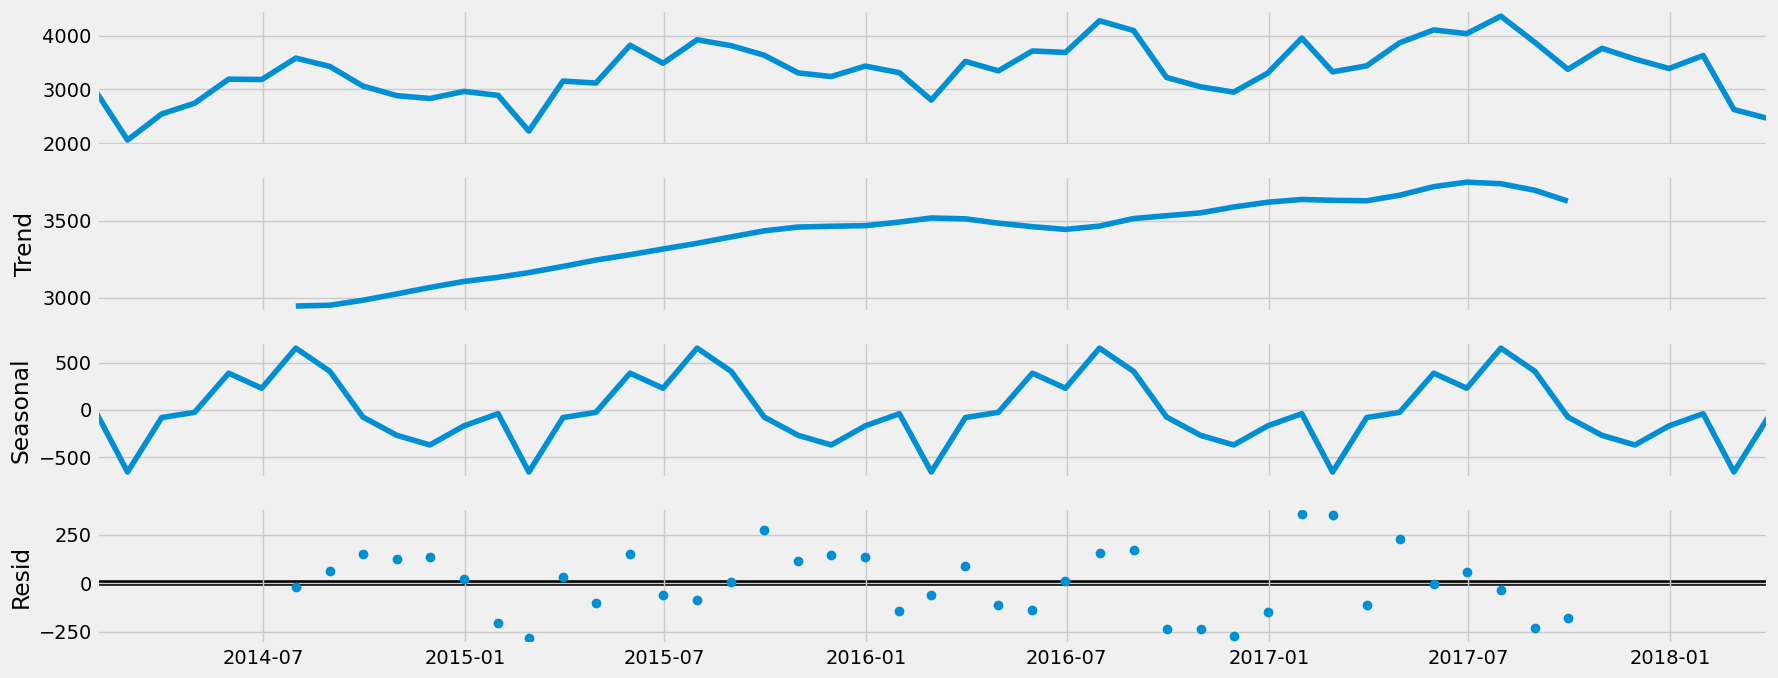

In [61]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The decomposition plot explained:
The decomposition plot separates the monthly aggregated time series data into its constituent components: level, trend, seasonality, and noise (also referred to as residual). Here's an analysis of each:
1-Level: Reflects the actual recorded data, exhibiting all combined components of the time series.

2-Trend: Shows a gradual increase over time, indicating a rising long-term movement in the dataset.

3-Seasonality: Demonstrates a repeating yearly pattern, suggesting periodic fluctuations in the data.

4-Noise: Appears random and stable, indicating the model has adequately captured the trend and seasonality, leaving no systematic patterns unexplained.


### 5. Conduct a Dickey-Fuller test to check for stationarity

In [62]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_aggregated_data['n_casualties'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.056827
p-value                         0.029918
Number of Lags Used             0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


#### Interpretation of the results:
To start with, the null hypothesis for the Dickey-Fuller test is that there is a unit root, meaning the time series is non-stationary. If we reject the null hypothesis, it suggests that the time series is stationary.

Interpreting the results:

-The test statistic is -3.056827 is lower (more negative) than the critical values at 5% level and 10% level.

-The p-value is approximately 0.03, which is less than the common significance level of 0.05.

Given that the test statistic is smaller than the critical values at 5% and 10% levels, and the p-value is below 0.05, we can reject the null hypothesis at the 5% and 10% level. This suggests that the time series is stationary at the 5%  (and by extension at the 10%) significance levels, implying that it does not have a unit root and there is evidence of stationarity in the data.

### 6. Check data’s autocorrelations

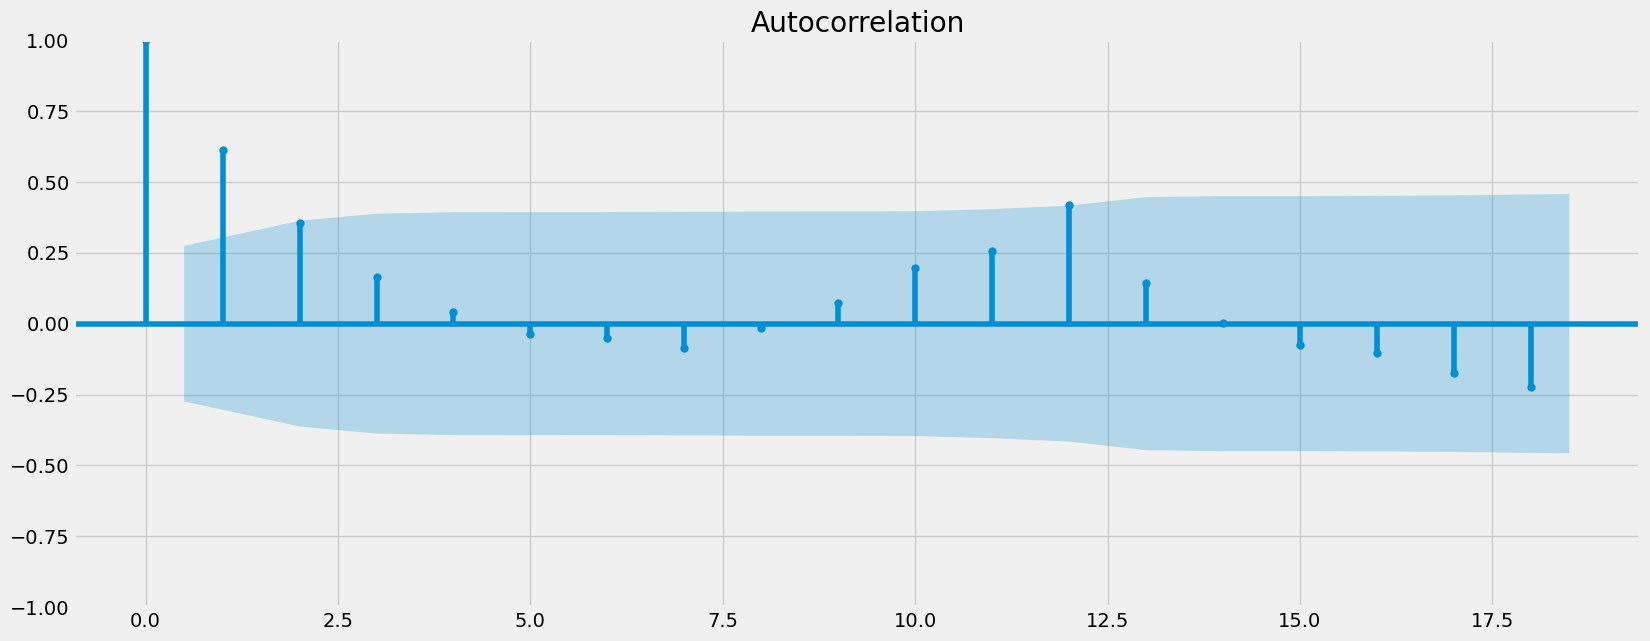

In [69]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots

plot_acf(monthly_aggregated_data)
plt.show()